In [27]:
# Import required libraries
import os
import xml.etree.ElementTree as ET

import torch
import torchvision
import matplotlib.pyplot as plt

# Define root directory (where data and annotations are located)
root_dir = "../Dataset"

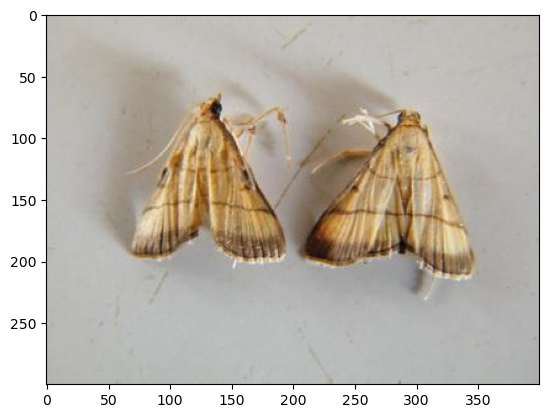

In [29]:
plt.imshow(image.permute(1,2,0))

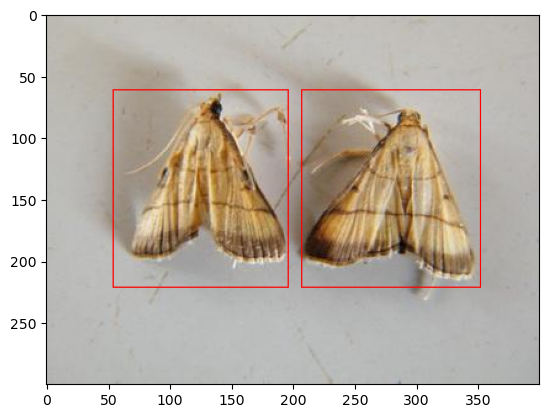

In [26]:
# Show an image from IP102 dataset with bounding boxes
image = torchvision.io.read_image(os.path.join(root_dir, "JPEGImages/IP000000002.jpg"))

# Getting bounding boxes coordinates of image and label
tree = ET.parse(os.path.join(root_dir, "Annotations/IP000000002.xml"))
root = tree.getroot()
objects = root.findall("object")
bboxes = []
labels = []
for obj in objects:
    l = int(obj.find("name").text)  # Get label
    # Get bounding box coordinates
    bbox = obj.find("bndbox")
    x0 = int(bbox.find("xmin").text)
    y0 = int(bbox.find("ymin").text)
    x1 = int(bbox.find("xmax").text)
    y1 = int(bndbox.find("ymax").text)
    
    bboxes.append([x0, y0, x1, y1])
    labels.append(l)

bboxes = torch.tensor(bboxes)
labels = torch.tensor(labels)
    
drawn_boxes = torchvision.utils.draw_bounding_boxes(image, bboxes, colors="red")
plt.imshow(drawn_boxes.permute(1, 2, 0))

In [18]:
sorted(os.listdir(os.path.join(root, "Annotations")))

['IP000000000.xml',
 'IP000000002.xml',
 'IP000000003.xml',
 'IP000000008.xml',
 'IP000000010.xml',
 'IP000000031.xml',
 'IP000000042.xml',
 'IP000000044.xml',
 'IP000000046.xml',
 'IP000000047.xml',
 'IP000000048.xml',
 'IP000000050.xml',
 'IP000000061.xml',
 'IP000000064.xml',
 'IP000000075.xml',
 'IP000000077.xml',
 'IP000000082.xml',
 'IP000000099.xml',
 'IP000000100.xml',
 'IP000000107.xml',
 'IP000000108.xml',
 'IP000000110.xml',
 'IP000000114.xml',
 'IP000000115.xml',
 'IP000000121.xml',
 'IP000000125.xml',
 'IP000000134.xml',
 'IP000000150.xml',
 'IP000000168.xml',
 'IP000000169.xml',
 'IP000000177.xml',
 'IP000000190.xml',
 'IP000000200.xml',
 'IP000000205.xml',
 'IP000000209.xml',
 'IP000000212.xml',
 'IP000000216.xml',
 'IP000000225.xml',
 'IP000000227.xml',
 'IP000000249.xml',
 'IP000000253.xml',
 'IP000000257.xml',
 'IP000000272.xml',
 'IP000000274.xml',
 'IP000000278.xml',
 'IP000000279.xml',
 'IP000000280.xml',
 'IP000000281.xml',
 'IP000000283.xml',
 'IP000000285.xml',
